# Install the required packages

In [1]:
%pip install captum timm shap grad-cam

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


# Import the required packages

In [2]:
import timm
import urllib
import torch

import numpy as np

import torchvision.transforms as T
import torch.nn.functional as F

from PIL import Image

from matplotlib.colors import LinearSegmentedColormap

import matplotlib.pyplot as plt

2022-11-04 03:20:06.910477: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-04 03:20:07.051611: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-04 03:20:07.051638: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-04 03:20:07.084132: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-04 03:20:07.917842: W tensorflow/stream_executor/pla

# Set the device to GPU

In [3]:
device = torch.device("cuda")

# Import the resnet18 model from timm and send it to evaluation mode# 

In [4]:
model = timm.create_model("resnet18", pretrained=True)
model.eval()
model = model.to(device)

# Download the Imagenet class lables

In [5]:
# Download human-readable labels for ImageNet.
# get the classnames
url, filename = (
    "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt",
    "imagenet_classes.txt",
)
urllib.request.urlretrieve(url, filename)
with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]


# Create the transforms

In [6]:
transform = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor()
])

transform_normalize = T.Normalize(
     mean=[0.485, 0.456, 0.406],
     std=[0.229, 0.224, 0.225]
)

# Import the 10 Images

In [7]:
# Imports PIL module 
from PIL import Image
  
# open method used to open different extension image file
images=[]
images.append(Image.open('Images/Mobile.jpeg'))
images.append(Image.open('Images/WaterBottle.jpeg'))
images.append(Image.open('Images/Dustbin.jpeg'))
images.append(Image.open('Images/CofferCup.jpeg'))
images.append(Image.open('Images/Switch.jpeg'))
images.append(Image.open('Images/MosquitoNet.jpeg'))
images.append(Image.open('Images/Mouse.jpeg'))
images.append(Image.open('Images/PuppyDoll.jpeg'))
images.append(Image.open('Images/WallClock.jpeg'))
images.append(Image.open('Images/Keyboard.jpeg'))

# Finding the indexes of 10 images by sending them the model

In [8]:
indexes=[]
for image in images:
    transformed_img = transform(image)
    img_tensor = transform_normalize(transformed_img)
    img_tensor = img_tensor.unsqueeze(0)
    img_tensor = img_tensor.to(device)
    output = model(img_tensor)
    output = F.softmax(output, dim=1)
    prediction_score, pred_label_idx = torch.topk(output, 1)  
    indexes.append(pred_label_idx.item())

# FGSM and PGD

In [9]:
from captum.robust import FGSM
from captum.robust import PGD

In [10]:
transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [11]:
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]
inv_transform= T.Compose([
    T.Normalize(
        mean = (-1 * np.array(mean) / np.array(std)).tolist(),
        std = (1 / np.array(std)).tolist()
    ),
])

In [12]:
def get_prediction(model, image: torch.Tensor):
    model = model.to(device)
    img_tensor = image.to(device)
    with torch.no_grad():
        output = model(img_tensor)
    output = F.softmax(output, dim=1)
    prediction_score, pred_label_idx = torch.topk(output, 1)

    pred_label_idx.squeeze_()
    predicted_label = categories[pred_label_idx.item()]

    return predicted_label, prediction_score.squeeze().item()

    # print('Predicted:', predicted_label, '(', prediction_score.squeeze().item(), ')')

In [13]:
def image_show(img, pred):
    npimg = inv_transform(img).squeeze().permute(1, 2, 0).detach().numpy()
    plt.imshow(npimg)
    plt.title("prediction: %s" % pred)
    plt.show()

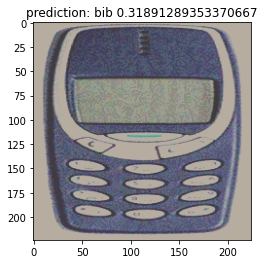

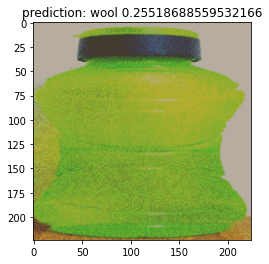

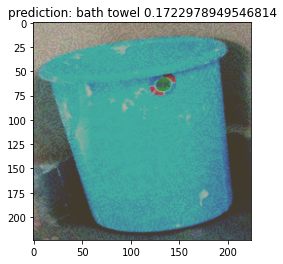

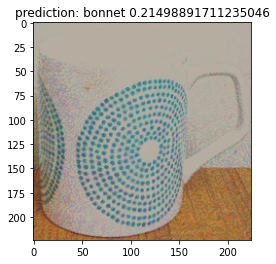

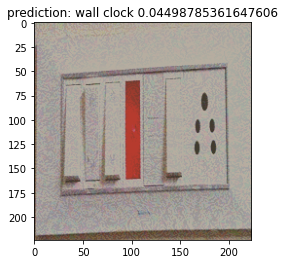

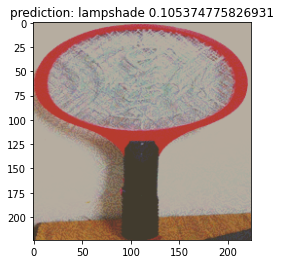

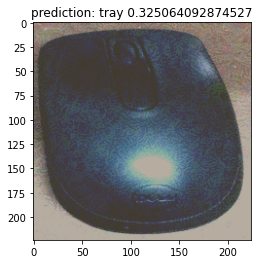

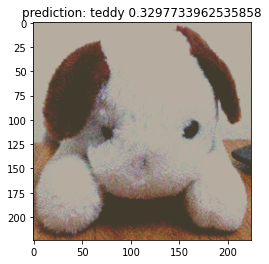

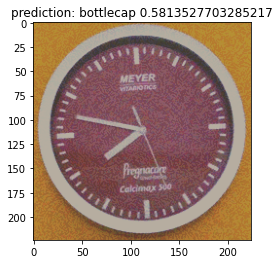

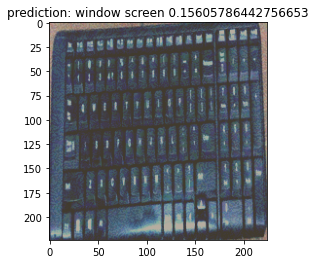

In [14]:
for i in range(len(images)):
    img_tensor = transform(images[i])
    img_tensor = img_tensor.unsqueeze(0)
    img_tensor.requires_grad = True
    img_tensor = img_tensor.to(device)
    # Construct FGSM attacker
    fgsm = FGSM(model, lower_bound=-1, upper_bound=1)
    perturbed_image_fgsm = fgsm.perturb(img_tensor, epsilon=0.16, target=indexes[i]) 
    new_pred_fgsm, score_fgsm = get_prediction(model, perturbed_image_fgsm)
    image_show(perturbed_image_fgsm.cpu(), new_pred_fgsm + " " + str(score_fgsm))

/home/jupyter-vit_abhinav/.local/lib/python3.9/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


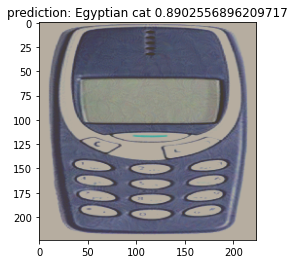

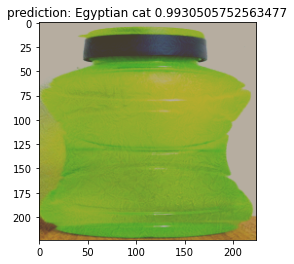

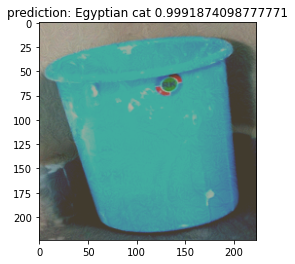

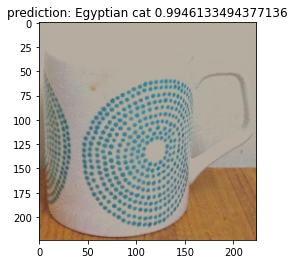

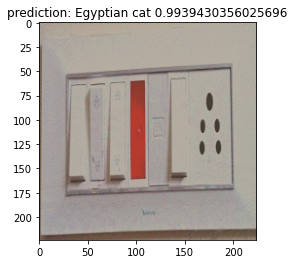

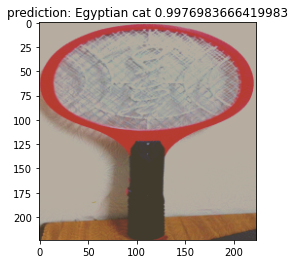

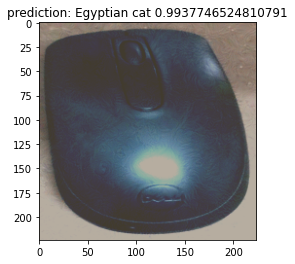

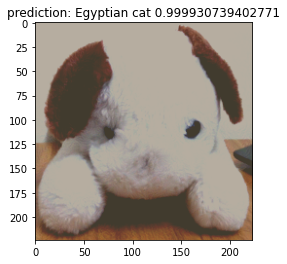

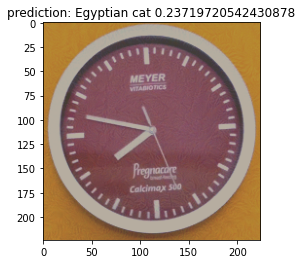

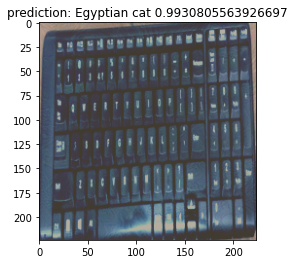

In [15]:
for i in range(len(images)):
    img_tensor = transform(images[i])
    img_tensor = img_tensor.unsqueeze(0)
    img_tensor.requires_grad = True
    img_tensor = img_tensor.to(device)
    pgd = PGD(model, torch.nn.CrossEntropyLoss(reduction='none'), lower_bound=-1, upper_bound=1)  # construct the PGD attacker

    perturbed_image_pgd = pgd.perturb(inputs=img_tensor, radius=0.13, step_size=0.02, 
                                      step_num=7, target=torch.tensor([285]).to(device), targeted=True) 
    new_pred_pgd, score_pgd = get_prediction(model, perturbed_image_pgd)
    image_show(perturbed_image_pgd.cpu(), new_pred_pgd + " " + str(score_pgd))